In [22]:
import numpy as np
from paramagpy import protein, dataparse, fit, metal
import matplotlib as mt
import copy as c
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MaxNLocator
from scipy.optimize import curve_fit as cf
import scipy.stats as sct
from tqdm import tqdm
import multiprocessing
import warnings
from Bio import PDB
from Bio.PDB.PDBExceptions import PDBConstructionWarning
warnings.simplefilter('ignore', PDBConstructionWarning)
from sklearn.model_selection import train_test_split as splt

### binning based on I helix

In [23]:
ith1 = np.loadtxt('../7_ith_kink/1_ith_318beta_distance/pairdist_ith_318b_p450_4jx1_apo.xvg', 
                 comments=['@','#'])[:,1]

In [24]:
ith1.shape

(195001,)

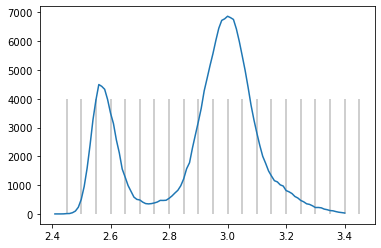

In [25]:
bins = np.linspace(2.4,3.4,101)
plt.plot(bins[1:], np.histogram(ith1,bins=bins)[0])
# plt.vlines(np.linspace(2.4,3.4,21), 0, 4000, color='gray', alpha=0.5)
plt.vlines(np.linspace(2.45,3.45,21), 0, 4000, color='gray', alpha=0.5)
plt.show()

In [5]:
ith1.min(), ith1.max()

(2.431, 3.519)

In [26]:
categories = np.linspace(2.45,3.45,21)
mcategories = categories[1:] - (categories[1]-categories[0])/2
categories[0], categories[-1] = 2.4, 3.55
mcategories.shape, categories

((20,),
 array([2.4 , 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95,
        3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.55]))

In [27]:
icategories = []
for b in range(1, categories.shape[0]):
    icategories.append(np.where((ith1>=categories[b-1])&(ith1<categories[b]))[0])
    print(np.round([categories[b-1],categories[b]],2), icategories[b-1].shape[0])

[2.4 2.5] 906
[2.5  2.55] 12588
[2.55 2.6 ] 20296
[2.6  2.65] 10776
[2.65 2.7 ] 3235
[2.7  2.75] 1858
[2.75 2.8 ] 2423
[2.8  2.85] 4311
[2.85 2.9 ] 11932
[2.9  2.95] 23044
[2.95 3.  ] 32858
[3.   3.05] 32000
[3.05 3.1 ] 18755
[3.1  3.15] 9078
[3.15 3.2 ] 4936
[3.2  3.25] 3103
[3.25 3.3 ] 1632
[3.3  3.35] 845
[3.35 3.4 ] 326
[3.4  3.55] 99


In [28]:
icategories2 = [np.where(ith1<2.75)[0], np.where(ith1>=2.75)[0]]
for i in icategories2:
    print(i.shape)

(49659,)
(145342,)


### functions

In [29]:
def get_percent_frames(ic, 
                       cv, cut0, cut1, otype='both',
                       random_state=0, ncv=5, bsize=0.2
                      ):
    '''
    ic - [list of lists] index categories
    cv - [2d-arr] the pcs fitting output (pcoms, dists etc)
    cut0 - [list of 2 ele] upper and lower limit of 0th cv
    cut1 - same as cut0, but 1st cv
    output - 
    percentile values/errors for each category
    '''
    np.random.seed(random_state)
    percents = np.zeros((len(ic),2))
    #
    for a,i in tqdm(enumerate(ic)):
        dcv = cv[i]
        #
        nobs = len(dcv)
        ncal = int(nobs*(1-bsize))
        dmeans = np.zeros((ncv,ncal,2))
        for n in range(ncv):
            dcal = dcv[np.random.permutation(nobs)[:ncal]]
            dmeans[n,:,0] = (dcal[:,0]>=cut0[0]) & (dcal[:,0]<=cut0[1])
            dmeans[n,:,1] = (dcal[:,1]>=cut1[0]) & (dcal[:,1]<=cut1[1])
        #
        dmeans = np.sum(dmeans, axis=2)
        if otype == 'both':
            dmeans = dmeans == 2
        elif otype == 'any':
            dmeans = dmeans >= 1
        else:
            raise ValueError(f'otype E [both, any]')
        #
        dmeans = np.sum(dmeans, axis=1)/dmeans.shape[1]
        percents[a] = [np.mean(dmeans), np.std(dmeans)]
        #
    return percents

def get_means(ic, cv, otype='both',
             random_state=0, ncv=5, bsize=0.2):
    '''
    ic, cv, - same as above (get_percent_frames)
    both - returns both separately, else return either 0 or 1
    random_state, ncv, bsize are same as above
    #
    this return mean values of cv as per ic categories, 
    the output shape is: (cv_index, category_index, mean/std)
    '''
    np.random.seed(random_state)
    means = np.zeros((2,len(ic),2))
    #
    for a,i in enumerate(ic):
        dcv = cv[i]
        #
        nobs = len(dcv)
        ncal = int(nobs*(1-bsize))
        dmeans = np.zeros((ncv,2))
        for n in range(ncv):
            dcal = dcv[np.random.permutation(nobs)[:ncal]]
            dmeans[n] = np.mean(dcal, axis=0)
        #
        means[:,a,0] = np.mean(dmeans, axis=0)
        means[:,a,1] = np.std(dmeans, axis=0)
    #
    if otype=='both':
        return means
    else:
        return means[otype]
    
def get_most_probable_dist(ic, dists, bwidth=0.01, otype='both',
                          random_state=0, ncv=5, bsize=0.2):
    '''
    return the most probable dist at each ic category based on probability distribution.
    in other words, it returns the peak of distribution
    #
    dists - 2d array of ca-ln distances,
    bwidth is bin width to build histogram on
    '''
    np.random.seed(random_state)
    bins = np.arange(dists.min(), dists.max()+bwidth, bwidth)
    mbins = bins[1:] - (bins[1]-bins[0])/2
    #
    probs = np.zeros((2,len(ic),2))
    for a,i in enumerate(ic):
        dcv = dists[i]
        #
        nobs = len(dcv)
        ncal = int(nobs*(1-bsize))
        dprobs = np.zeros((ncv,2))
        for n in range(ncv):
            dcal = dcv[np.random.permutation(nobs)[:ncal]]
            for b,d in enumerate(dcal.T):
                dprobs[n,b] = mbins[np.argmax(np.histogram(d, bins=bins)[0])]
        #
        probs[:,a,0] = np.mean(dprobs, axis=0)
        probs[:,a,1] = np.std(dprobs, axis=0)
    #
    if otype=='both':
        return probs
    else:
        return probs[otype]
    
def get_pdist(ic, dists, 
              bwidth=0.01,
             random_state=0, ncv=5, bsize=0.2):
    '''
    it return complete distribution plots for each category
    '''
    np.random.seed(random_state)
    bins = np.arange(dists.min(), dists.max()+bwidth, bwidth)
    mbins = bins[1:] - (bins[1]-bins[0])/2
    #
    probs = np.zeros((2,len(ic),len(mbins),2))
    for a,i in enumerate(ic):
        dcv = dists[i]
        #
        nobs = len(dcv)
        ncal = int(nobs*(1-bsize))
        dprobs = np.zeros((ncv,len(mbins),2))
        for n in range(ncv):
            dcal = dcv[np.random.permutation(nobs)[:ncal]]
            for b,d in enumerate(dcal.T):
                dprobs[n,:,b] = np.histogram(d, bins=bins, density=False)[0]/d.shape[0]
        probs[:,a,:,0] = np.mean(dprobs, axis=0).T
        probs[:,a,:,1] = np.std(dprobs, axis=0).T
    #
    return mbins, probs

def get_conditional_mean(ic, qscores, 
                         dists, cut=[5.5,10.5],
                        random_state=0, ncv=5, bsize=0.2):
    '''
    for every ic, means of qscores - with dists satisfied as per cut
    '''
    np.random.seed(random_state)
    means = np.zeros((len(ic),2))
    #
    for a,i in enumerate(ic):
        dq = qscores[i]
        dd = dists[i]
        #
        nobs = len(i)
        ncal = int(nobs*(1-bsize))
        dmeans = np.zeros((ncv))
        for n in range(ncv):
            ddd = np.random.permutation(nobs)[:ncal]
            #
            ddq = dq[ddd]
            ddd = dd[ddd]
            #
            ddd = (ddd>=cut[0]) & (ddd<=cut[1])
            ddd = np.where(np.sum(ddd, axis=1)==2)[0]
            ddq = ddq[ddd]
            #
            dmeans[n] = np.mean(ddq)
        #
        means[a] = [np.mean(dmeans), np.std(dmeans)]
        #
    return means


def qdivision(q, d, cut):
    ind = np.sum((d>=cut[0]) & (d<=cut[1]), axis=1)
    ind = ind == 2
    return q[ind], q[~ind]

### based on ln distances

In [30]:
names = ['static','substrate-free','with_cam']
var = ['hn', 'sf', 'cam']

In [31]:
dists_ = [np.load(f'saved_pcs/2_output_files/dists_{n}.npy') for n in names]

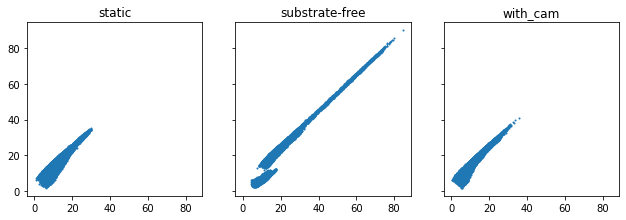

In [95]:
fig,ax=plt.subplots(1,3,figsize=(9,3),sharex=True,sharey=True)
plt.tight_layout()
for a,d in enumerate(dists_):
    ax[a].scatter(*d.T, s=1)
    ax[a].set_title(names[a])
plt.show()

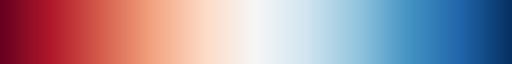

In [12]:
cmaps = mt.cm.get_cmap('RdBu')
cmaps

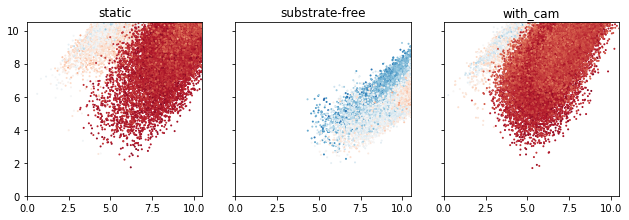

In [62]:
fig,ax=plt.subplots(1,3,figsize=(9,3), sharex=True, sharey=True)
plt.tight_layout()
for a,d in enumerate(dists_):
    ax[a].scatter(*d.T, s=1,
               color=cmaps((ith1-ith1.min())/(ith1.max()-ith1.min()))
               )
    ax[a].set_title(names[a])
ax[0].set_xlim(0,10.5)
ax[0].set_ylim(0,10.5)
plt.show()

In [32]:
cuts = [
    [7,9],       # strict cutoff - as per structural constraints
    [6,10],      # slightly loose cutoff
    [5.5,10.5]   # loose cutoff based on crystal resolutions, benchmarking, and literature 
]

In [33]:
dpercents = [
    [
        get_percent_frames(icategories, d, cut0=cut, cut1=cut, bsize=0.3)
    for d in dists_]
for cut in cuts]

20it [00:00, 267.90it/s]
20it [00:00, 342.65it/s]
20it [00:00, 372.17it/s]
20it [00:00, 372.52it/s]
20it [00:00, 374.79it/s]
20it [00:00, 372.76it/s]
20it [00:00, 367.91it/s]
20it [00:00, 370.47it/s]
20it [00:00, 375.93it/s]


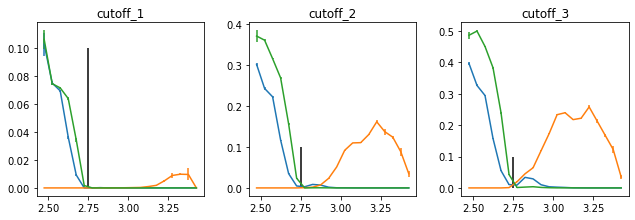

In [15]:
fig,ax=plt.subplots(1,3,figsize=(9,3), sharex=True)
plt.tight_layout()
for a,c in enumerate(dpercents):
    for d in c: ax[a].errorbar(mcategories, d[:,0], yerr=d[:,1])
    ax[a].vlines(2.75, 0, 0.1, color='black')
    ax[a].set_title(f'cutoff_{a+1}')
plt.show()

In [34]:
dpercents2 = [
    [
        get_percent_frames(icategories2, d, cut0=cut, cut1=cut, bsize=0.3)
    for d in dists_]
for cut in cuts]
np.round(dpercents2[-1], 3)

2it [00:00, 23.80it/s]
2it [00:00, 33.78it/s]
2it [00:00, 35.35it/s]
2it [00:00, 31.86it/s]
2it [00:00, 32.40it/s]
2it [00:00, 33.98it/s]
2it [00:00, 33.74it/s]
2it [00:00, 34.31it/s]
2it [00:00, 34.59it/s]


array([[[0.25 , 0.001],
        [0.007, 0.   ]],

       [[0.   , 0.   ],
        [0.177, 0.001]],

       [[0.421, 0.001],
        [0.001, 0.   ]]])

In [35]:
dpdx = np.load('saved_pcs/2_output_files/dists_with_pdx.npy')

In [37]:
dpdx=np.round(get_percent_frames(icategories, dpdx, cut0=[5.5,10.5], cut1=[5.5,10.5], bsize=0.3), 3)

20it [00:00, 267.92it/s]


<ErrorbarContainer object of 3 artists>

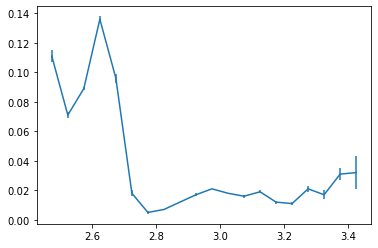

In [38]:
plt.errorbar(mcategories, dpdx[:,0], yerr=dpdx[:,1])

### q scores

In [39]:
qscores = [np.load(f'saved_pcs/2_output_files/qscores_{n}.npy') for n in names]

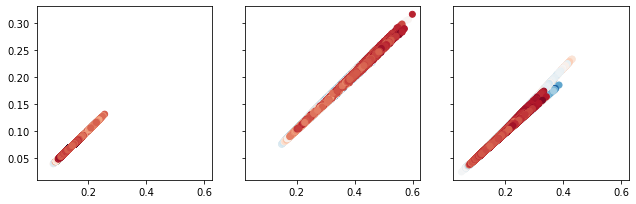

In [153]:
fig,ax=plt.subplots(1,3,figsize=(9,3),sharex=True,sharey=True)
plt.tight_layout()
for a,d in enumerate(qscores): ax[a].scatter(*d.T, c=ith1, cmap='RdBu')
plt.show()

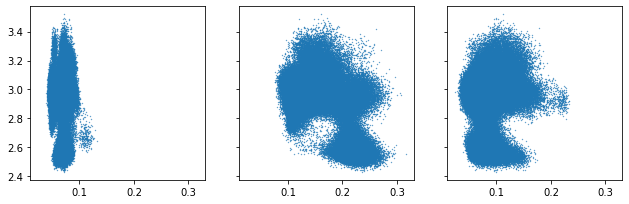

In [156]:
fig,ax=plt.subplots(1,3,figsize=(9,3),sharex=True,sharey=True)
plt.tight_layout()
for a,d in enumerate(qscores): ax[a].scatter(d[:,1], ith1, s=0.1)
plt.show()

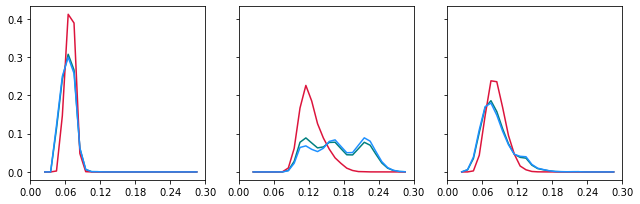

In [74]:
bins = np.arange(0.02,0.3,0.01)
xb = bins[1:]-(bins[1]-bins[0])/2
fig,ax=plt.subplots(1,3,figsize=(9,3),sharex=True,sharey=True)
plt.tight_layout()
colors=['crimson', 'dodgerblue']
for a,d in enumerate(qscores): 
    ax[a].plot(xb, np.histogram(d[:,1], bins=bins, density=False)[0]/d[:,1].shape[0], color='teal')
    dd = qdivision(d[:,1], dists_[a], cuts[-1])
    for b,d in enumerate(dd):
        ax[a].plot(xb, np.histogram(d, bins=bins, density=False)[0]/d.shape[0], color=colors[b])
ax[0].set_xticks(np.linspace(0,0.3,6))
plt.show()

In [16]:
cq = [
    get_conditional_mean(icategories, qscores[a][:,1], d, cut=cuts[-1], bsize=0.3)
for a,d in enumerate(dists_)]

/home/msahil/softwares/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/msahil/softwares/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


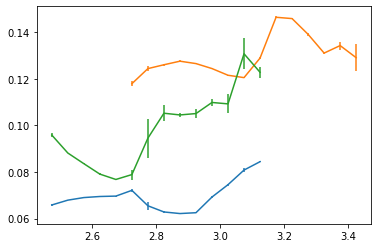

In [28]:
for i in cq: plt.errorbar(mcategories, i[:,0], yerr=i[:,1])

### pcoms

In [11]:
pcoms = [np.load(f'saved_pcs/2_output_files/pcoms_{n}.npy') for n in names]

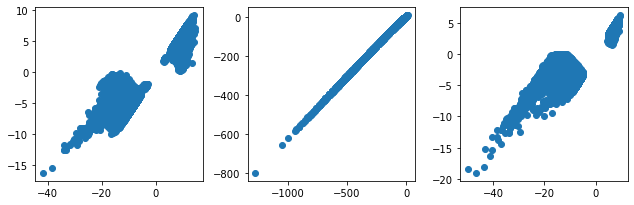

In [61]:
fig,ax=plt.subplots(1,3,figsize=(9,3),sharex=False,sharey=False)
plt.tight_layout()
for a,d in enumerate(pcoms): ax[a].scatter(*d.T)
plt.show()

#### checking only the positive thing

In [84]:
positivess = [
    get_percent_frames(icategories, p, cut0=[0,15], cut1=[0,15], bsize=0.3)
for p in pcoms]

20it [00:00, 252.63it/s]
20it [00:00, 387.06it/s]
20it [00:00, 338.91it/s]


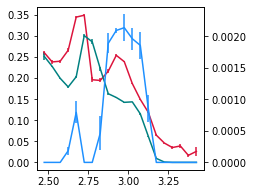

In [91]:
fig,ax=plt.subplots(1,figsize=(3,3))
bx = ax.twinx()
axes, colors = [ax,bx,ax], ['crimson', 'dodgerblue', 'teal']
for a,p in enumerate(positivess): axes[a].errorbar(mcategories, p[:,0], yerr=p[:,1], color=colors[a])
plt.show()

In [16]:
abss = [
    get_percent_frames(icategories, np.abs(p), cut0=[4,8], cut1=[5,10], bsize=0.3)
for p in pcoms]


20it [00:00, 275.71it/s]
20it [00:00, 344.53it/s]
20it [00:00, 359.47it/s]


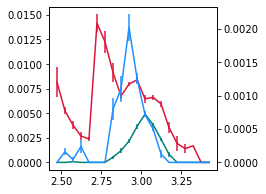

In [17]:
fig,ax=plt.subplots(1,figsize=(3,3))
bx = ax.twinx()
axes, colors = [ax,bx,ax], ['crimson', 'dodgerblue', 'teal']
for a,p in enumerate(abss): axes[a].errorbar(mcategories, p[:,0], yerr=p[:,1], color=colors[a])
plt.show()

### final plots

In [40]:
colors = ['dodgerblue', 'crimson', 'teal']
fmt=['o', 's', 'v']

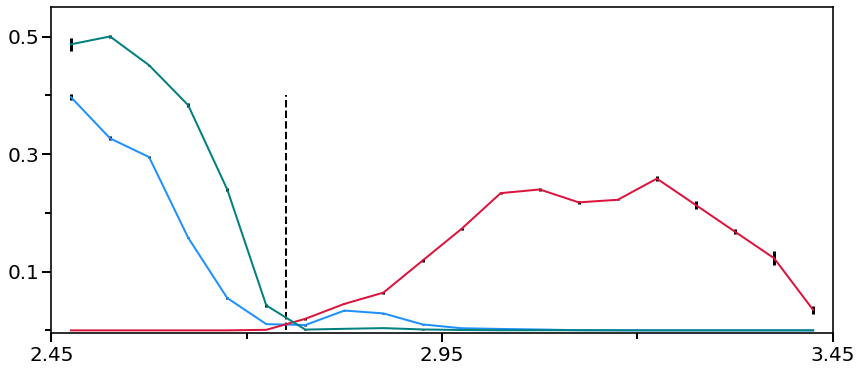

In [96]:
cut=2
fig,ax=plt.subplots(1, figsize=(14,6))
for a,d in enumerate(dpercents[cut]):
    ax.errorbar(mcategories, d[:,0], yerr=d[:,1],
                color=colors[a], lw=2, ecolor='black', elinewidth=3)
ax.plot([2.75,2.75], [0,0.4], '--', lw=2, color='black')
ax.set_xlim(2.45, 3.45)
ax.set_ylim(-0.005,0.55)
ax.set_xticks([2.45, 2.95, 3.45])
ax.set_yticks([0.1, 0.3, 0.5])
ax.spines[:].set_linewidth(1.6)
ax.tick_params(length=9, width=2, labelsize=20)
ax.axes.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.axes.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='minor', length=6, width=2)
#
plt.savefig(f'saved_pcs/3_output_plots/fraction2_cut{cut}.pdf')
plt.show()

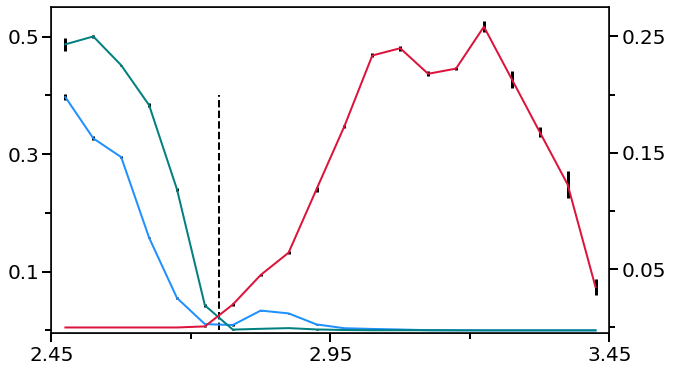

In [82]:
cut=2
fig,ax=plt.subplots(1, figsize=(10,6))
bx = ax.twinx()
axes = [ax,bx,ax]
for a,d in enumerate(dpercents[cut]):
    axes[a].errorbar(mcategories, d[:,0], yerr=d[:,1],
                color=colors[a], lw=2, ecolor='black', elinewidth=3)
ax.plot([2.75,2.75], [0,0.4], '--', lw=2, color='black')
ax.set_xlim(2.45, 3.45)
ax.set_ylim(-0.005,0.55)
bx.set_ylim(-0.005,0.275)
ax.set_xticks([2.45, 2.95, 3.45])
ax.set_yticks([0.1, 0.3, 0.5])
bx.set_yticks([0.05, 0.15, 0.25])
ax.spines[:].set_linewidth(1.6)
ax.tick_params(length=9, width=2, labelsize=20)
bx.tick_params(length=9, width=2, labelsize=20)
ax.axes.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.axes.yaxis.set_minor_locator(AutoMinorLocator(2))
bx.axes.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='minor', length=6, width=2)
bx.tick_params(which='minor', length=6, width=2)
#
plt.savefig(f'saved_pcs/3_output_plots/fraction_cut{cut}.pdf')
plt.show()

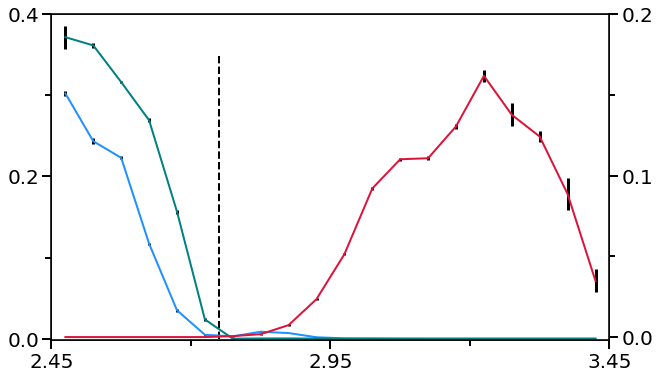

In [87]:
cut=1
fig,ax=plt.subplots(1, figsize=(10,6))
bx = ax.twinx()
axes = [ax,bx,ax]
for a,d in enumerate(dpercents[cut]):
    axes[a].errorbar(mcategories, d[:,0], yerr=d[:,1],
                color=colors[a], lw=2, ecolor='black', elinewidth=3)
ax.plot([2.75,2.75], [0,0.35], '--', lw=2, color='black')
ax.set_xlim(2.45, 3.45)
ax.set_ylim(-0.002,0.4)
bx.set_ylim(-0.002,0.2)
ax.set_xticks([2.45, 2.95, 3.45])
ax.set_yticks([0, 0.2, 0.4])
bx.set_yticks([0, 0.1, 0.2])
ax.spines[:].set_linewidth(1.6)
ax.tick_params(length=9, width=2, labelsize=20)
bx.tick_params(length=9, width=2, labelsize=20)
ax.axes.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.axes.yaxis.set_minor_locator(AutoMinorLocator(2))
bx.axes.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='minor', length=6, width=2)
bx.tick_params(which='minor', length=6, width=2)
#
plt.savefig(f'saved_pcs/3_output_plots/fraction_cut{cut}.pdf')
plt.show()

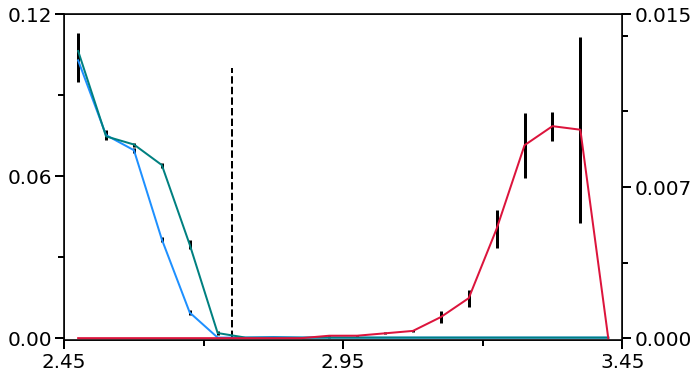

In [101]:
cut=0
fig,ax=plt.subplots(1, figsize=(10,6))
bx = ax.twinx()
axes = [ax,bx,ax]
for a,d in enumerate(dpercents[cut]):
    axes[a].errorbar(mcategories, d[:,0], yerr=d[:,1],
                color=colors[a], lw=2, ecolor='black', elinewidth=3)
ax.plot([2.75,2.75], [0,0.1], '--', lw=2, color='black')
ax.set_xlim(2.45, 3.45)
ax.set_ylim(-0.001,0.12)
bx.set_ylim(-0.0001,0.015)
ax.set_xticks([2.45, 2.95, 3.45])
ax.set_yticks([0, 0.06, 0.12])
bx.set_yticks([0, 0.007, 0.015])
ax.spines[:].set_linewidth(1.6)
ax.tick_params(length=9, width=2, labelsize=20)
bx.tick_params(length=9, width=2, labelsize=20)
ax.axes.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.axes.yaxis.set_minor_locator(AutoMinorLocator(2))
bx.axes.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='minor', length=6, width=2)
bx.tick_params(which='minor', length=6, width=2)
#
plt.savefig(f'saved_pcs/3_output_plots/fraction_cut{cut}.pdf')
plt.show()

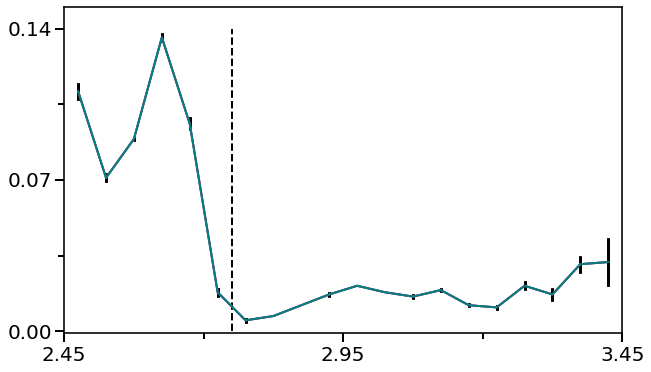

In [99]:
fig,ax=plt.subplots(1, figsize=(10,6))
for a,d in enumerate(dpercents[cut]):
    ax.errorbar(mcategories, dpdx[:,0], yerr=dpdx[:,1],
                color=colors[a], lw=2, ecolor='black', elinewidth=3)
ax.plot([2.75,2.75], [0,0.14], '--', lw=2, color='black')
ax.set_xlim(2.45, 3.45)
ax.set_ylim(-0.001,0.15)
ax.set_xticks([2.45, 2.95, 3.45])
ax.set_yticks([0, 0.07, 0.14])
ax.spines[:].set_linewidth(1.6)
ax.tick_params(length=9, width=2, labelsize=20)
ax.axes.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.axes.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='minor', length=6, width=2)
#
plt.savefig(f'saved_pcs/3_output_plots/fraction_pdx.pdf')
plt.show()

In [3]:
path='saved_pcs/0_data_from_ubbink'
pcs = [
    dataparse.read_pcs(f'{path}/static_exp_closed_HN.npc'),
    dataparse.read_pcs(f'{path}/observed_pcs_substrate-free_errors.npc'),
    dataparse.read_pcs(f'{path}/observed_pcs_with_cam_errors.npc'),
    dataparse.read_pcs(f'{path}/observed_pcs_with_cam_pdx_errors.npc')
]

Line ignored while reading file: saved_pcs/0_data_from_ubbink/observed_pcs_substrate-free_errors.npc
134 N 

Line ignored while reading file: saved_pcs/0_data_from_ubbink/observed_pcs_substrate-free_errors.npc
289 N 



In [4]:
pcs = [np.array(list(i.values())) for i in pcs]

In [5]:
names1 = ['HN', 'substrate-free', 'with_cam', 'with_pdx']
path = 'saved_pcs/2_output_files'
means = [np.load(f'{path}/means_{i}.npy') for i in names1]
stds = [np.load(f'{path}/stds_{i}.npy') for i in names1]

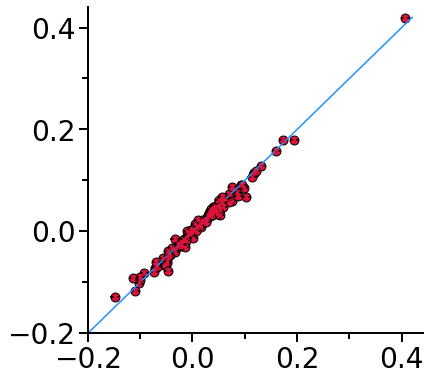

In [115]:
p=0
fig,ax=plt.subplots(1, figsize=(6,6))
ax.errorbar(pcs[p][:,0], means[p], 
           xerr=pcs[p][:,1], yerr=stds[p],
           fmt='.', color='crimson', ecolor='black',)
ax.scatter(pcs[p][:,0], means[p], color='crimson', s=80, edgecolor='black')
ax.plot([-0.2,0.42], [-0.2, 0.42], color='dodgerblue')
ax.set_xlim(-0.2,0.44)
ax.set_ylim(-0.2,0.44)
ax.set_xticks([-0.2, 0, 0.2, 0.4])
ax.set_yticks([-0.2, 0, 0.2, 0.4])
ax.spines[:].set_linewidth(2)
ax.tick_params(length=9, width=2, labelsize=28)
ax.axes.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.axes.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='minor', length=6, width=2)
ax.spines[['right','top']].set_visible(False)
#
plt.savefig(f'saved_pcs/3_output_plots/pcs_{names1[p]}_ensemble.pdf')
plt.show()

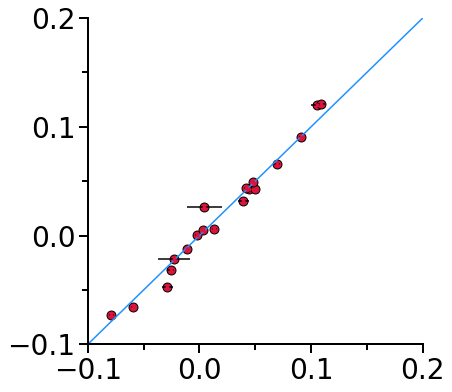

In [117]:
p=1
fig,ax=plt.subplots(1, figsize=(6,6))
ax.errorbar(pcs[p][:,0], means[p], 
           xerr=pcs[p][:,1], yerr=stds[p],
           fmt='.', color='crimson', ecolor='black',)
ax.plot([-0.1,0.2], [-0.1, 0.2], color='dodgerblue')
ax.scatter(pcs[p][:,0], means[p], color='crimson', s=80, edgecolor='black')
ax.set_xlim(-0.1,0.2)
ax.set_ylim(-0.1,0.2)
ax.set_xticks([-0.1, 0, 0.1, 0.2])
ax.set_yticks([-0.1, 0, 0.1, 0.2])
ax.spines[:].set_linewidth(2)
ax.tick_params(length=9, width=2, labelsize=20)
ax.axes.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.axes.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='minor', length=6, width=2)
ax.spines[['right','top']].set_visible(False)
#
plt.savefig(f'saved_pcs/3_output_plots/pcs_{names1[p]}_ensemble.pdf')
plt.show()

In [45]:
[
    np.sqrt(np.sum(np.square(pcs[p][:,0] - means[p]))/np.sum(np.square(pcs[p][:,0] + means[p])))
    for p in range(4)]

[0.0606531625593798,
 0.10872765669289229,
 0.07762167392136039,
 0.090836114382512]